### CNN with Image Augmentation (CIFAR10)
images of 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. In RGB, 32x32 pixels. The state of the art accuracy is 96.53 percent.


In [25]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

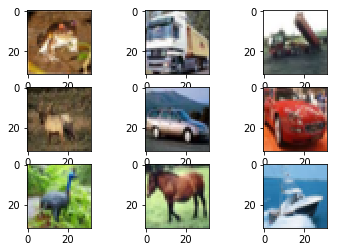

In [26]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

In [27]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)

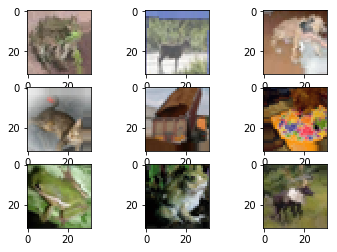

In [28]:
# see example augmentation images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [29]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [30]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [31]:
# labels
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)

In [56]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [51]:
# build and compile the model  (roughly following the VGG paper)

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
num_filters=32
ac='relu'
adm=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(512, activation=ac,kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 64)        18496     
__________

In [52]:
# training without augmentation
history=model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 105s 2ms/step - loss: 1.4918 - acc: 0.5133 - val_loss: 1.2996 - val_acc: 0.5478
Epoch 2/100
50000/50000 [==============================] - 73s 1ms/step - loss: 0.8839 - acc: 0.6890 - val_loss: 0.8540 - val_acc: 0.7108
Epoch 3/100
50000/50000 [==============================] - 71s 1ms/step - loss: 0.6853 - acc: 0.7616 - val_loss: 0.7038 - val_acc: 0.7577
Epoch 4/100
50000/50000 [==============================] - 71s 1ms/step - loss: 0.5741 - acc: 0.7990 - val_loss: 0.6799 - val_acc: 0.7748
Epoch 5/100
50000/50000 [==============================] - 71s 1ms/step - loss: 0.4838 - acc: 0.8305 - val_loss: 0.6797 - val_acc: 0.7764
Epoch 6/100
50000/50000 [==============================] - 71s 1ms/step - loss: 0.4058 - acc: 0.8572 - val_loss: 0.6821 - val_acc: 0.7831
Epoch 7/100
50000/50000 [==============================] - 71s 1ms/step - loss: 0.3400 - acc: 0.8816 - val_loss: 0.6651 -

50000/50000 [==============================] - 71s 1ms/step - loss: 0.0256 - acc: 0.9911 - val_loss: 1.1473 - val_acc: 0.8180
Epoch 60/100
50000/50000 [==============================] - 70s 1ms/step - loss: 0.0194 - acc: 0.9933 - val_loss: 1.1226 - val_acc: 0.8210
Epoch 61/100
50000/50000 [==============================] - 70s 1ms/step - loss: 0.0253 - acc: 0.9909 - val_loss: 1.1875 - val_acc: 0.8174
Epoch 62/100
50000/50000 [==============================] - 70s 1ms/step - loss: 0.0229 - acc: 0.9926 - val_loss: 1.1580 - val_acc: 0.8205
Epoch 63/100
50000/50000 [==============================] - 71s 1ms/step - loss: 0.0250 - acc: 0.9915 - val_loss: 1.1892 - val_acc: 0.8137
Epoch 64/100
50000/50000 [==============================] - 71s 1ms/step - loss: 0.0259 - acc: 0.9911 - val_loss: 1.1308 - val_acc: 0.8208
Epoch 65/100
50000/50000 [==============================] - 71s 1ms/step - loss: 0.0225 - acc: 0.9923 - val_loss: 1.1524 - val_acc: 0.8206
Epoch 66/100
50000/50000 [==============

In [53]:
#training accuracy without dropout
train_acc=model.evaluate(x_train,y_train,batch_size=128)
train_acc

50000/50000 [==============================] - 23s 452us/step


[0.001993330870848149, 0.99939999999999996]

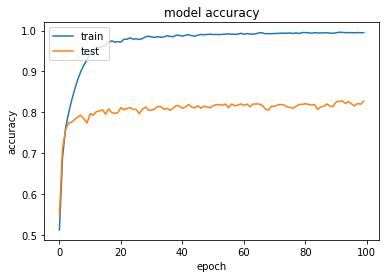

In [60]:
plothist(history)

In [127]:
#model.save('cifar10_01.h5')                  
#model=load_model('cifar10_01.h5')

In [34]:
# build again, same model as model1

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg2=None
num_filters2=32
ac2='relu'
adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt2=adm2
drop_dense2=0.5
drop_conv2=0

model2 = Sequential()

model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model2.add(Dropout(drop_conv2))

model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model2.add(Dropout(drop_conv2))

model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model2.add(Dropout(drop_conv2))

model2.add(Flatten())
model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
model2.add(BatchNormalization())
model2.add(Dropout(drop_dense2))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

In [35]:
# train with image augmentation
history2=model2.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
                    steps_per_epoch = len(x_train) / 128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
391/390 [==============================] - 106s 272ms/step - loss: 1.6073 - acc: 0.4661 - val_loss: 1.3294 - val_acc: 0.5226
Epoch 2/100
391/390 [==============================] - 71s 182ms/step - loss: 1.0941 - acc: 0.6148 - val_loss: 0.8888 - val_acc: 0.6878
Epoch 3/100
391/390 [==============================] - 71s 182ms/step - loss: 0.9122 - acc: 0.6787 - val_loss: 0.7557 - val_acc: 0.7307
Epoch 4/100
391/390 [==============================] - 70s 180ms/step - loss: 0.8082 - acc: 0.7150 - val_loss: 0.7181 - val_acc: 0.7479
Epoch 5/100
391/390 [==============================] - 71s 181ms/step - loss: 0.7442 - acc: 0.7393 - val_loss: 0.6809 - val_acc: 0.7643
Epoch 6/100
391/390 [==============================] - 71s 181ms/step - loss: 0.6942 - acc: 0.7544 - val_loss: 0.6384 - val_acc: 0.7817
Epoch 7/100
391/390 [==============================] - 71s 181ms/step - loss: 0.6465 - acc: 0.7752 - val_loss: 0.5781 - val_acc: 0.8008
Epoch 8/100
391/390 [==========================

Epoch 61/100
391/390 [==============================] - 69s 178ms/step - loss: 0.2121 - acc: 0.9261 - val_loss: 0.3299 - val_acc: 0.8972
Epoch 62/100
391/390 [==============================] - 69s 177ms/step - loss: 0.2107 - acc: 0.9250 - val_loss: 0.3235 - val_acc: 0.9022
Epoch 63/100
391/390 [==============================] - 69s 177ms/step - loss: 0.2028 - acc: 0.9281 - val_loss: 0.3272 - val_acc: 0.8979
Epoch 64/100
391/390 [==============================] - 69s 178ms/step - loss: 0.2044 - acc: 0.9288 - val_loss: 0.3256 - val_acc: 0.8989
Epoch 65/100
391/390 [==============================] - 69s 177ms/step - loss: 0.2003 - acc: 0.9295 - val_loss: 0.3353 - val_acc: 0.8943
Epoch 66/100
391/390 [==============================] - 69s 177ms/step - loss: 0.1975 - acc: 0.9299 - val_loss: 0.3303 - val_acc: 0.8991
Epoch 67/100
391/390 [==============================] - 70s 178ms/step - loss: 0.1987 - acc: 0.9305 - val_loss: 0.3282 - val_acc: 0.9004
Epoch 68/100
391/390 [===================

In [40]:
#model2.save('cifar10_02.h5')         #90.26, (128 batch, 0.001 lr, 512 neurons, no zoom, no convdrop, only 0.1 shift) 

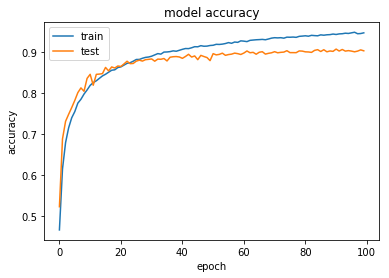

In [49]:
plothist(history2)  # 128 batch, 0.001 lr, 512 neurons, no zoom, no convdrop, only 0.1 shift

In [46]:
model2_test_acc=model2.evaluate(x_test,y_test,batch_size=128)
model2_test_acc

10000/10000 [==============================] - 4s 436us/step


[0.34665883693695071, 0.90259999999999996]

In [47]:
model2_train_acc=model2.evaluate(x_train,y_train,batch_size=128)
model2_train_acc

50000/50000 [==============================] - 21s 416us/step


[0.046460947413444517, 0.98502000003814694]